<a href="https://colab.research.google.com/github/hwp28/hwp28/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%A2%85%EC%82%AC%EC%9E%90%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 import 
# 패키지 및 라이브러리 import
import pandas as pd                       # dataframe
import numpy as np                        # array등 수치데이터 처리 
import matplotlib.pyplot as plt           # 그래프 

# 머신러닝 라이브러리 
from sklearn.model_selection import train_test_split

# 딥러닝 라이브러리 
from keras.utils import plot_model        # keras 모델 이미지 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input

# keras 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

# 구글 드라이브 마운트 ( 자원 접근 권한 관련 )
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 학습용 전체 데이터 import 
df = pd.read_csv('/content/drive/My Drive/project/2013_2019_분기별 종사자수.csv')
df.head()
df.columns

Index(['REG_DT', 'DIVIDE', 'Care practician', 'Electron practician ', 'TOTAL'], dtype='object')

In [ ]:
# 전처리
# 전체 데이터(df_total: 전체종업자수)와 세부 데이터(df_care:보건) /(df_electron:전기운수업) 를 나눠서 학습 
df_total = df[['REG_DT','DIVIDE','TOTAL']]                        # 전체 취업자
df_care  = df[['REG_DT','DIVIDE','Care practician']]              # 보건업체 종사자
df_electron = df[['REG_DT','DIVIDE','Electron practician ']]      # 전기운수업 종사자
# df_electron = 
df_care = df_care.rename(columns={'Care practician':'CP'})                            # 컬럼명 길어서 변경 

In [ ]:
df_electron.rename(columns={'Electron practician ':'EP'},inplace=True)  # 컬럼명 길어서 변경 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_electron

,REG_DT,DIVIDE,EP
0,2013,1,1464
1,2013,2,1578
2,2013,3,1610
3,2013,4,1611
4,2014,1,1587
5,2014,2,1724
6,2014,3,1760
7,2014,4,1764
8,2015,1,1708
9,2015,2,1787


In [ ]:
df_total = df_total.drop(['DIVIDE'], axis=1)
df_total

,REG_DT,TOTAL
0,2013,24412
1,2013,25539
2,2013,25632
3,2013,25614
4,2014,25210
5,2014,26092
6,2014,26226
7,2014,26062
8,2015,25543
9,2015,26341


In [ ]:
##############################################################################
# 함수 time split ( 연(year) 단위로 데이터 묶음)
##############################################################################
def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column # 수정

        if y_end_number > len(dataset):  # 수정
            break
        tmp_x = dataset[i:x_end_number, :]  # 수정
        tmp_y = dataset[x_end_number:y_end_number, 1]    # 수정
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

In [ ]:
x1, y1 = split_xy(df_total.values, 4, 1) # 4분기(1년치 데이터를 기준으로) 다음 1분기를 예측한다.

In [ ]:
x1

array([[[ 2013, 24412],
        [ 2013, 25539],
        [ 2013, 25632],
        [ 2013, 25614]],

       [[ 2013, 25539],
        [ 2013, 25632],
        [ 2013, 25614],
        [ 2014, 25210]],

       [[ 2013, 25632],
        [ 2013, 25614],
        [ 2014, 25210],
        [ 2014, 26092]],

       [[ 2013, 25614],
        [ 2014, 25210],
        [ 2014, 26092],
        [ 2014, 26226]],

       [[ 2014, 25210],
        [ 2014, 26092],
        [ 2014, 26226],
        [ 2014, 26062]],

       [[ 2014, 26092],
        [ 2014, 26226],
        [ 2014, 26062],
        [ 2015, 25543]],

       [[ 2014, 26226],
        [ 2014, 26062],
        [ 2015, 25543],
        [ 2015, 26341]],

       [[ 2014, 26062],
        [ 2015, 25543],
        [ 2015, 26341],
        [ 2015, 26465]],

       [[ 2015, 25543],
        [ 2015, 26341],
        [ 2015, 26465],
        [ 2015, 26362]],

       [[ 2015, 26341],
        [ 2015, 26465],
        [ 2015, 26362],
        [ 2016, 25747]],

       [[ 2015, 2646

In [24]:
# 보건업 종사자 관련 데이터 Standard Scaling 
x2 = df_care[df_care['REG_DT'] >= 2014]
x2 = x2.drop(['REG_DT'], axis=1)
# df_care 데이터 전처리 
from sklearn.model_selection import train_test_split
x2_train, x2_test = train_test_split(x2, random_state=1,  test_size = 0.3)

#### 데이터 Scaling #####
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x2_train)
x2_train_scaled = scaler.transform(x2_train)
x2_test_scaled = scaler.transform(x2_test)

In [25]:
# 데이터 전처리 
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state=1,  test_size = 0.3)

# Standard Scaling 하기 위해 2차원 배열로 변경
x1_train = np.reshape(x1_train, (x1_train.shape[0], x1_train.shape[1] * x1_train.shape[2])) 
x1_test = np.reshape(x1_test, (x1_test.shape[0], x1_test.shape[1] * x1_test.shape[2]))

# #### 데이터 Scaling #####
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler1.fit(x1_train)
x1_train_scaled = scaler1.transform(x1_train)
x1_test_scaled = scaler1.transform(x1_test)
x1_train_scaled = np.reshape(x1_train_scaled, (x1_train_scaled.shape[0], 4, 2))
x1_test_scaled = np.reshape(x1_test_scaled, (x1_test_scaled.shape[0], 4, 2)) # 7일 단위 3개 feature 데이터를 저장 

In [26]:
# 데이터 전처리 
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state=1,  test_size = 0.3)

In [27]:
# 모델 생성 및 학습 ( PV, RLORD_AMT 에 대한 lstm )
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM

study_size = 4 # 1년(4분기)
feature_size = 1 # 년도별 취업자수 feature 보겠다는 의미 

input1 = Input(shape=(study_size, 2))
dense1 = LSTM(64)(input1)
dense1 = Dense(32)(dense1)
dense1 = Dense(32)(dense1)
output1 = Dense(1)(dense1)
model1 = Model(inputs=[input1], outputs = output1)


# model1 = models.model_create_timeseries_for_concatenate(7, 3) # 7일단위 ( memory cell ) 2개 feature 데이터를 저장 
model1.compile(loss='mae', optimizer='adam')
model1.fit([x1_train_scaled], y1_train, validation_split=0.2, verbose=1, batch_size=2000, epochs=500)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 26410.5625 - val_loss: 26201.5020
Epoch 2/500
1/1 [==============================] - 0s 53ms/step - loss: 26410.5273 - val_loss: 26201.4844
Epoch 3/500
1/1 [==============================] - 0s 56ms/step - loss: 26410.4922 - val_loss: 26201.4688
Epoch 4/500
1/1 [==============================] - 0s 56ms/step - loss: 26410.4551 - val_loss: 26201.4531
Epoch 5/500
1/1 [==============================] - 0s 64ms/step - loss: 26410.4121 - val_loss: 26201.4336
Epoch 6/500
1/1 [==============================] - 0s 73ms/step - loss: 26410.3672 - val_loss: 26201.4141
Epoch 7/500
1/1 [==============================] - 0s 72ms/step - loss: 26410.3203 - val_loss: 26201.3945
Epoch 8/500
1/1 [==============================] - 0s 81ms/step - loss: 26410.2695 - val_loss: 26201.3691
Epoch 9/500
1/1 [==============================] - 0s 68ms/step - loss: 26410.2129 - val_loss: 26201.3457
Epoch 10/500
1/1 [==============================

In [28]:
# y1_pred = lstm 모델 (PV, RLORD_AMT, ORD_CNT) 로 예측한 RLORD_AMT 
loss = model1.evaluate([x1_train_scaled], y1_train, batch_size=1)
print('loss : ', loss)

y1_pred = model1.predict([x1_train_scaled])
print('<<<<<<<<<<model 1 예측>>>>>>>>>>')
for i in range(5):    
    print('매출금액(실제) : ', y1_test[i], '/ 매출금액(예측) : ', y1_pred[i], '정확도(%) : ', y1_pred[i] / y1_test[i] * 100, '오차 : ',np.absolute(y1_test[i]-y1_pred[i]).astype(int))

19/19 [==============================] - 1s 3ms/step - loss: 352.2773
loss :  352.2772521972656
<<<<<<<<<<model 1 예측>>>>>>>>>>
매출금액(실제) :  [26749] / 매출금액(예측) :  [26365.625] 정확도(%) :  [98.56676885] 오차 :  [383]
매출금액(실제) :  [27019] / 매출금액(예측) :  [26132.54] 정확도(%) :  [96.71912011] 오차 :  [886]
매출금액(실제) :  [26971] / 매출금액(예측) :  [26813.672] 정확도(%) :  [99.41667671] 오차 :  [157]
매출금액(실제) :  [26461] / 매출금액(예측) :  [26645.42] 정확도(%) :  [100.69694993] 오차 :  [184]
매출금액(실제) :  [26998] / 매출금액(예측) :  [26808.217] 정확도(%) :  [99.29704718] 오차 :  [189]


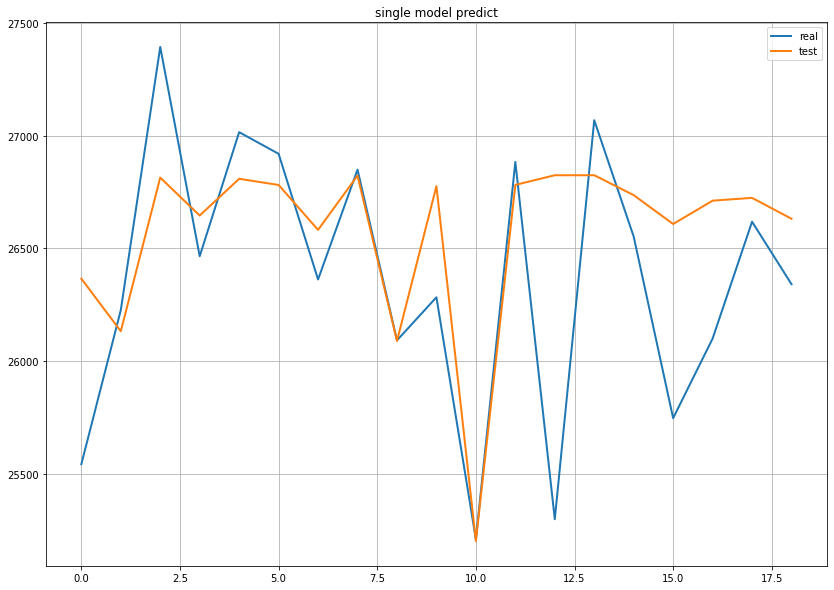

In [29]:
# y1_pred 실제값과 비교한 그래프 
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (14,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

plt.plot(y1_train)
plt.plot(y1_pred)
plt.title('single model predict')
plt.legend(['real', 'test'])

In [30]:
# 비선형 학습 세트 추가 
df_care = df_care.drop(['DIVIDE'], axis=1)

In [31]:
# non linear model modeling 
dim = 2 # 입력 feature가 1개니까 
model2 = keras.Sequential()
model2.add(layers.Dense(10, input_dim=dim, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1))  
model2.add(layers.Activation('relu'))

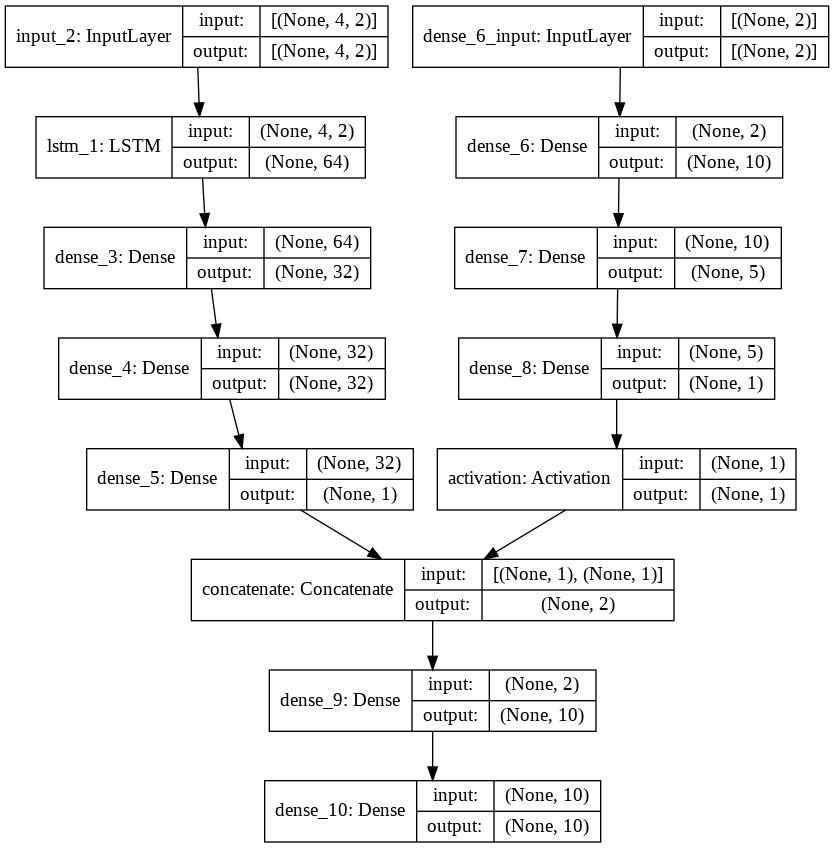

In [32]:
# Keras Concatenate 
from tensorflow.keras.layers import concatenate
combinedInput = concatenate([model1.output, model2.output])
x = Dense(10, activation="relu")(combinedInput)
x = Dense(10, activation="relu")(x)
model_merged = Model(inputs=[model1.input, model2.input], outputs=x)
plot_model(model_merged, to_file='model_merged.png', show_shapes=True)

In [33]:
print(x1_train_scaled.shape)
print(x2_train_scaled.shape)

(19, 4, 2)
(19, 2)


In [34]:
# fitting 
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.1)
model_merged.compile(loss="mae", optimizer=opt)
hist = model_merged.fit(	
  [x1_train_scaled, x2_train_scaled], y1_train,  
  validation_split=0.2, 	
 	epochs=500,	batch_size=800)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 24799.6250 - val_loss: 24546.9277
Epoch 2/500
1/1 [==============================] - 0s 64ms/step - loss: 24714.5918 - val_loss: 23732.7324
Epoch 3/500
1/1 [==============================] - 0s 55ms/step - loss: 23898.0332 - val_loss: 24470.4805
Epoch 4/500
1/1 [==============================] - 0s 62ms/step - loss: 24995.0293 - val_loss: 24835.9160
Epoch 5/500
1/1 [==============================] - 0s 75ms/step - loss: 25049.3164 - val_loss: 24902.4121
Epoch 6/500
1/1 [==============================] - 0s 71ms/step - loss: 25112.2578 - val_loss: 24782.6250
Epoch 7/500
1/1 [==============================] - 0s 60ms/step - loss: 24992.2754 - val_loss: 24475.2422
Epoch 8/500
1/1 [==============================] - 0s 59ms/step - loss: 24684.9590 - val_loss: 23908.9121
Epoch 9/500
1/1 [==============================] - 0s 62ms/step - loss: 24118.8477 - val_loss: 24233.8203
Epoch 10/500
1/1 [==============================

In [ ]:
loss = model_merged.evaluate([x1_train_scaled, x2_train_scaled], y1_train, batch_size=1)
print('loss : ', loss)
y_pred = model_merged.predict([x1_train_scaled, x2_train_scaled])
print('<<<<<<<<<<merged model 예측>>>>>>>>>>')
for i in range(10):    
    print('매출금액(실제) : ', y1_train[i])
    print('매출금액(예측) : ', y1_pred[i].astype(int)) 
    print('오차           : ', np.absolute(y1_train[i] - y1_pred[i]).astype(int))    
    print('오차율(%)      : ', abs(y1_train[i]-y1_pred[i]) / y1_pred[i]*100)
    print()          

19/19 [==============================] - 0s 2ms/step - loss: 10854.7500
loss :  10854.75
<<<<<<<<<<merged model 예측>>>>>>>>>>
매출금액(실제) :  [25543]
매출금액(예측) :  [26300]
오차           :  [757]
오차율(%)      :  [2.87958197]

매출금액(실제) :  [26226]
매출금액(예측) :  [26158]
오차           :  [67]
오차율(%)      :  [0.25700929]

매출금액(실제) :  [27393]
매출금액(예측) :  [26694]
오차           :  [698]
오차율(%)      :  [2.61587806]

매출금액(실제) :  [26465]
매출금액(예측) :  [26543]
오차           :  [78]
오차율(%)      :  [0.2959317]

매출금액(실제) :  [27015]
매출금액(예측) :  [26689]
오차           :  [325]
오차율(%)      :  [1.22104738]

매출금액(실제) :  [26919]
매출금액(예측) :  [26662]
오차           :  [256]
오차율(%)      :  [0.96380035]

매출금액(실제) :  [26362]
매출금액(예측) :  [26484]
오차           :  [122]
오차율(%)      :  [0.4624466]

매출금액(실제) :  [26849]
매출금액(예측) :  [26704]
오차           :  [144]
오차율(%)      :  [0.54198972]

매출금액(실제) :  [26092]
매출금액(예측) :  [26124]
오차           :  [32]
오차율(%)      :  [0.12468057]

매출금액(실제) :  [26283]
매출금액(예측) :  [26656]
오차           :  [373]

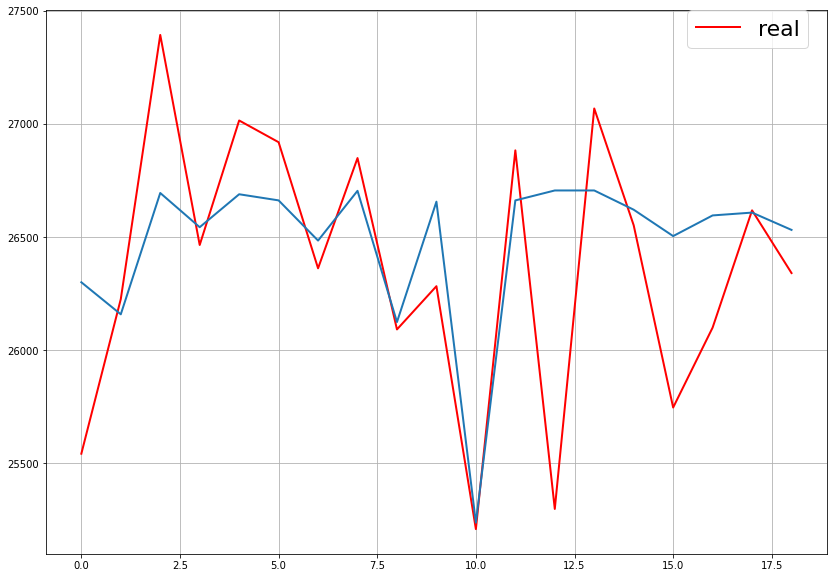

In [ ]:
# 1. LSTM + Non-linear(relu) 구성시 정확도 그래프 
plt.plot(y1_train, color='r')
plt.plot(y1_pred)
plt.legend(['real'], prop={'size': 22}, bbox_to_anchor=(0.99, 1.02))

In [39]:
# 2. LSTM + LSTM 구성시 정확도 
# x1, y1은 그대로 
# x2, y2는 lstm 
x2, y2 = split_xy(df_care.values, 4, 1) # 4분기(1년치 데이터를 기준으로) 다음 1분기를 예측한다.

# 데이터 전처리 
from sklearn.model_selection import train_test_split
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, random_state=1,  test_size = 0.3)

# Standard Scaling 하기 위해 2차원 배열로 변경
x2_train = np.reshape(x2_train, (x2_train.shape[0], x2_train.shape[1] * x2_train.shape[2])) 
x2_test = np.reshape(x2_test, (x2_test.shape[0], x2_test.shape[1] * x2_test.shape[2]))

# #### 데이터 Scaling #####
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler1.fit(x2_train)
x2_train_scaled = scaler1.transform(x2_train)
x2_test_scaled = scaler1.transform(x2_test)
x2_train_scaled = np.reshape(x2_train_scaled, (x2_train_scaled.shape[0], 4, 2))
x2_test_scaled = np.reshape(x2_test_scaled, (x2_test_scaled.shape[0], 4, 2)) # 7일 단위 3개 feature 데이터를 저장 

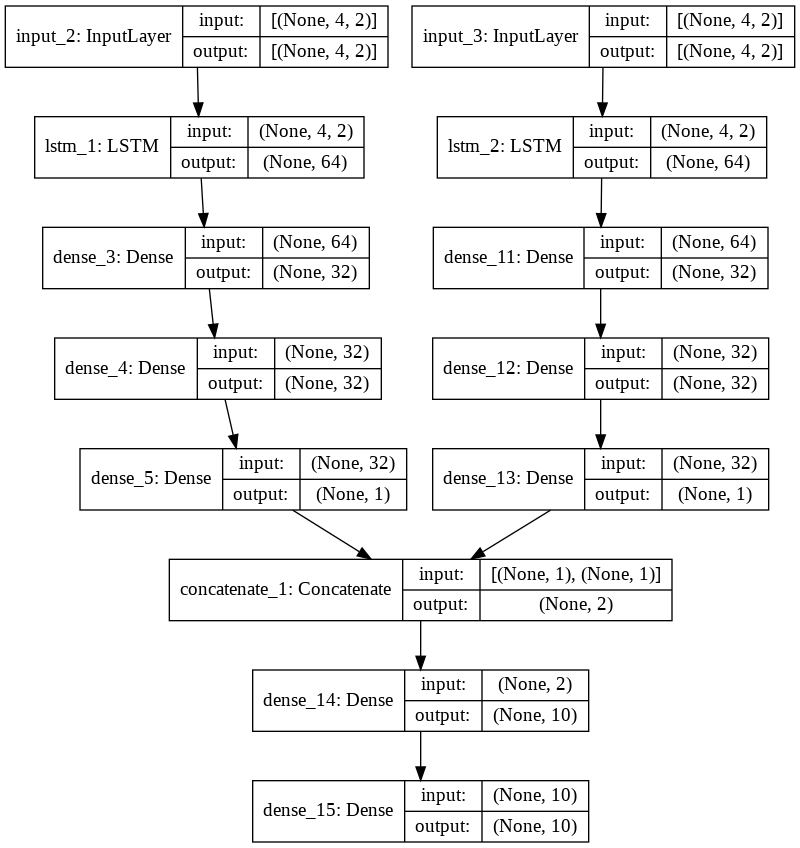

In [36]:
# model2 remodeling ( model2는 nonlinear 였기 때문에 lstm으로 재구성)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM

study_size = 4   # 1년(4분기)
feature_size = 1 # 년도별 취업자수 feature 보겠다는 의미 

input2 = Input(shape=(study_size, 2))
dense2 = LSTM(64)(input2)
dense2 = Dense(32)(dense2)
dense2 = Dense(32)(dense2)
output2 = Dense(1)(dense2)
model2 = Model(inputs=[input2], outputs = output2)

# Keras Concatenate 
from tensorflow.keras.layers import concatenate
combinedInput = concatenate([model1.output, model2.output])
x = Dense(10, activation="relu")(combinedInput)
x = Dense(10, activation="relu")(x)
model_merged = Model(inputs=[model1.input, model2.input], outputs=x)
plot_model(model_merged, to_file='model_merged.png', show_shapes=True)

In [2]:
# fitting 
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.1)
model_merged.compile(loss="mae", optimizer=opt)

hist = model_merged.fit(	
  [x1_train_scaled, x2_train_scaled], y2_train,  
  validation_split=0.2, 	
 	epochs=500,	batch_size=800)

NameError: ignored

In [1]:
loss = model_merged.evaluate([x1_train_scaled, x2_train_scaled], y2_train, batch_size=1)
print('loss : ', loss)
y2_pred = model_merged.predict([x1_train_scaled, x2_train_scaled])
print('<<<<<<<<<<merged model 예측>>>>>>>>>>')
for i in range(10):    
    print('(실제) : ', y2_train[i])
    print('(예측) : ', y2_pred[i].astype(int))     
    print('오차           : ', np.absolute(y2_train[i] - y2_pred[i]).astype(int))    
    print('정확도(%)      : ', y2_pred[i] / y2_train[i] * 100)

NameError: ignored

In [43]:
# np.delete(y2_pred, np.where(y2_pred.astype(int)==0.0))
index = np.where(y2_pred == 0.).index

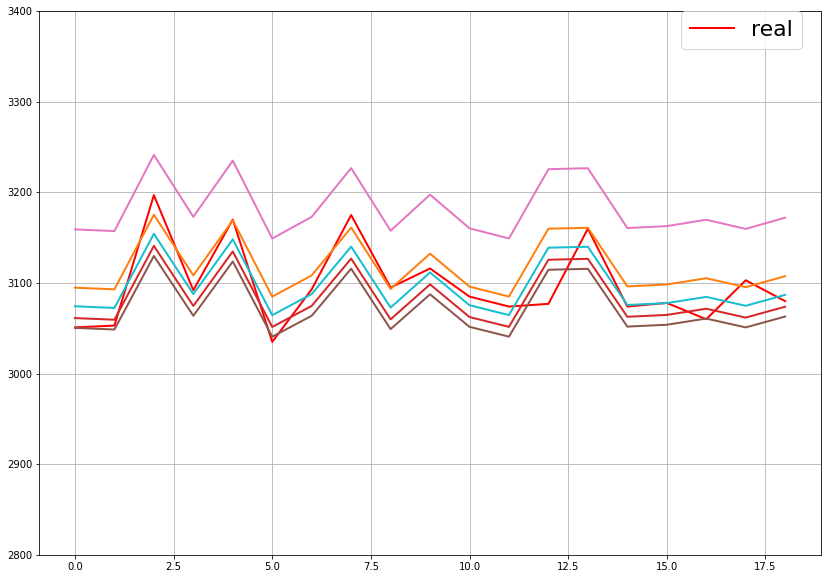

In [44]:
# 1. LSTM + Non-linear(relu) 구성시 정확도 그래프 
plt.plot(y2_train, color='r')
plt.plot(y2_pred)
plt.ylim(2800, 3400)
plt.legend(['real'], prop={'size': 22}, bbox_to_anchor=(0.99, 1.02))